# Time Series Assignment 3

In [146]:
import kagglehub
path = kagglehub.dataset_download("jeanmidev/smart-meters-in-london")

In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

## Reading The Data

In [148]:
block = pd.read_csv(os.path.join(path, 'hhblock_dataset/hhblock_dataset/block_10.csv'),  parse_dates=['day'])
block

,LCLid,day,hh_0,hh_1,hh_2,hh_3,hh_4,hh_5,hh_6,hh_7,...,hh_38,hh_39,hh_40,hh_41,hh_42,hh_43,hh_44,hh_45,hh_46,hh_47
0,MAC000322,2012-03-07,0.125,0.104,0.133,0.145,0.109,0.298,0.149,0.119,...,0.087,0.092,0.187,0.130,0.096,0.096,0.137,0.101,0.137,0.485
1,MAC000322,2012-03-08,0.279,0.247,0.253,0.275,0.114,0.105,0.117,0.141,...,0.105,0.132,0.252,0.105,0.096,0.129,0.120,0.070,0.039,0.074
2,MAC000322,2012-03-09,0.036,0.130,0.364,0.120,0.100,0.118,0.146,0.105,...,0.028,0.030,0.072,0.038,0.029,0.046,0.069,0.029,0.050,0.520
3,MAC000322,2012-03-10,0.435,0.093,0.105,0.138,0.099,0.096,0.133,0.129,...,0.120,0.125,0.115,0.101,0.142,0.112,0.099,0.150,0.152,0.097
4,MAC000322,2012-03-11,0.187,0.122,0.094,0.109,0.139,0.099,0.111,0.137,...,0.036,0.100,0.358,0.122,0.095,0.111,0.141,0.097,0.095,0.122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31473,MAC005354,2014-02-23,0.103,0.069,0.101,0.144,0.080,0.061,0.105,0.130,...,0.078,0.098,0.124,0.130,0.116,0.110,0.112,0.130,0.086,0.126
31474,MAC005354,2014-02-24,0.100,0.109,0.088,0.121,0.086,0.084,0.101,0.103,...,0.064,0.114,0.135,0.141,0.081,0.130,0.128,0.090,0.109,0.152
31475,MAC005354,2014-02-25,0.110,0.069,0.103,0.140,0.082,0.061,0.112,0.129,...,0.084,0.076,0.134,0.150,0.104,0.080,0.124,0.122,0.122,0.095
31476,MAC005354,2014-02-26,0.130,0.102,0.086,0.102,0.105,0.096,0.062,0.115,...,0.067,0.102,0.134,0.122,0.098,0.086,0.145,0.106,0.090,0.121


In [149]:
def convert_standard_form_to_expand_time_series(standard_df, verbose=False):
   # Similar to compact steps
  expand_df = pd.melt(standard_df, id_vars=['day','LCLid'],value_name='energy_consumption',var_name='offset')
  expand_df['offset'] = expand_df['offset'].str.replace('hh_','').astype(int)
  expand_df = expand_df.sort_values(by=['day','offset']).reset_index(drop=True)
#   expand_df['frequency'] = '30min'
#   expand_df['serie_length'] = len(expand_df)
  ## Here we resample our day column to construct a timestamp column with frequenct 30min
  expand_df['timestamp'] = pd.date_range(start=standard_df['day'].min(), freq='30min', periods=len(expand_df))
  ## Drop unnecessary columns
  expand_df = expand_df.drop(columns=['day','offset'])
#   expand_df = expand_df[['LCLid','timestamp','energy_consumption','frequency','serie_length']]
  expand_df = expand_df[['LCLid','timestamp','energy_consumption']]
  if verbose:
    display(expand_df)
  return expand_df


In [150]:
block_id =block[block['LCLid'] == 'MAC000322']
expanded_df = convert_standard_form_to_expand_time_series(block_id)
expanded_df

,LCLid,timestamp,energy_consumption
0,MAC000322,2012-03-07 00:00:00,0.125
1,MAC000322,2012-03-07 00:30:00,0.104
2,MAC000322,2012-03-07 01:00:00,0.133
3,MAC000322,2012-03-07 01:30:00,0.145
4,MAC000322,2012-03-07 02:00:00,0.109
...,...,...,...
34507,MAC000322,2014-02-23 21:30:00,0.116
34508,MAC000322,2014-02-23 22:00:00,0.108
34509,MAC000322,2014-02-23 22:30:00,0.129
34510,MAC000322,2014-02-23 23:00:00,0.058


# Box-Jenkins

## Step 1: Preprocessing the data

In [114]:
df = expanded_df.drop('LCLid', axis=1).set_index('timestamp')
df

,energy_consumption
timestamp,
2012-03-07 00:00:00,0.125
2012-03-07 00:30:00,0.104
2012-03-07 01:00:00,0.133
2012-03-07 01:30:00,0.145
2012-03-07 02:00:00,0.109
...,...
2014-02-23 21:30:00,0.116
2014-02-23 22:00:00,0.108
2014-02-23 22:30:00,0.129


In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34512 entries, 2012-03-07 00:00:00 to 2014-02-23 23:30:00
Data columns (total 1 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   energy_consumption  34511 non-null  float64
dtypes: float64(1)
memory usage: 539.2 KB


In [116]:
df.describe()

,energy_consumption
count,34511.000000
mean,0.106438
std,0.105291
min,0.009000
25%,0.053000
50%,0.083000
75%,0.124000
max,1.159000


In [117]:
df[df['energy_consumption'].isna()]

,energy_consumption
timestamp,
2012-12-14 15:00:00,NaN


In [118]:
df['energy_consumption'] = df['energy_consumption'].interpolate(method='spline', order=3)
df['energy_consumption'].isna().sum()

np.int64(0)

In [119]:
weekly_df = df.resample('1W').sum()

In [160]:
def run_seq_plot(consumption, title, x_label='Time', y_label='Consumption'):
    time = consumption.index
    plt.figure(figsize=(18,6))
    plt.plot(time, consumption)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid(alpha=0.3)

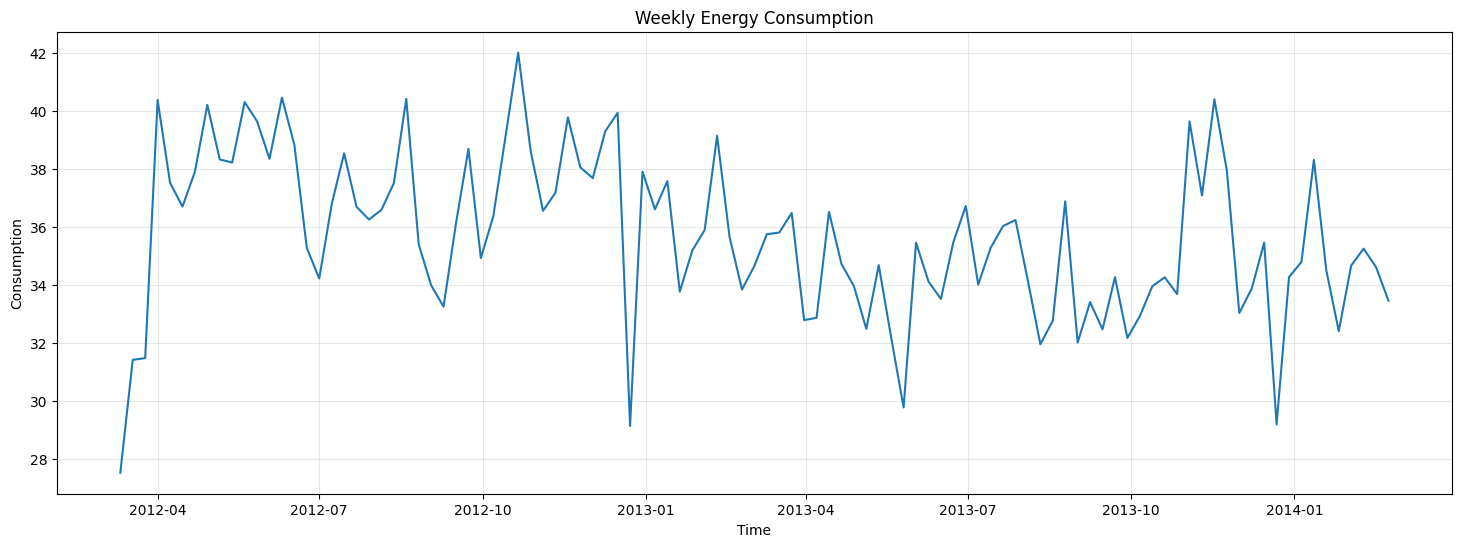

In [161]:
run_seq_plot(weekly_df, 'Weekly Energy Consumption')

### Check for Stationarity

In [135]:
def check_stationary(data):
    """
    Checks the if passed pd.Series is stationary or not using ADF and Kpss
    """

    assert isinstance(data, (pd.Series, np.ndarray)), "Data must be a pandas Series or numpy ndarray"

    # Check ADF
    adf, adf_pvalue, usedlag, nobs, critical_values, icbest = adfuller(data)
    print('ADF'.center(50, '-'))
    print(adf, adf_pvalue, critical_values, sep='\n')
    if adf_pvalue <0.05:
        print(f'Pvalue {adf_pvalue} is less than 0.05 so rejecting null hypo. Thus the data is Stationary')
        adf_test = 'Stationary'
    else:
        print(f'Pvalue {adf_pvalue} is higher than 0.05 so can\'t reject null hypo. Thus the data is Non Stationary')
        adf_test = 'Non Stationary'
    print('-'*50, end='\n\n')


    # Check KPSS
    print('Kpss'.center(50, '-'))
    kpss_, kpss_pvalue_, usedlag_, critical_values_, = kpss(data, nlags='auto')
    print(kpss_, kpss_pvalue_, critical_values_, sep='\n')
    if kpss_pvalue_ >=0.05:
        print(f'Pvalue {kpss_pvalue_} is higher than 0.05 so can\'t reject null hypo. Thus the data is Stationary')
        kpss_test = 'Stationary'
    else:
        print(f'Pvalue {kpss_pvalue_} is less than 0.05 so we reject the null hypo. Thus the data is Non Stationary')
        kpss_test = 'Non Stationary'
    print('-'*50, end='\n\n')

    if adf_test == kpss_test == 'Stationary':
        print('Data is stationary')
    elif adf_test == kpss_test == 'Non Stationary':
        print('Data is Non Stationary')

    elif (adf_test == 'Stationary') and (kpss_test == 'Non Stationary'):
        print('='*50, end='\n\n')
        print('Data is difference stationary. Differencing is to be used to make data stationary')
        print('='*50, end='\n\n')

    else:
        print('='*50, end='\n\n')
        print('Data is trend stationary. Trend needs to be removed to make data stirct stationary')
        print('='*50, end='\n\n')


In [136]:
from statsmodels.tsa.stattools import adfuller, kpss

check_stationary(weekly_df['energy_consumption'])

-----------------------ADF------------------------
-2.6992488065577165
0.07416834854238563
{'1%': np.float64(-3.498198082189098), '5%': np.float64(-2.891208211860468), '10%': np.float64(-2.5825959973472097)}
Pvalue 0.07416834854238563 is higher than 0.05 so can't reject null hypo. Thus the data is Non Stationary
--------------------------------------------------

-----------------------Kpss-----------------------
0.7524360141723917
0.01
{'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Pvalue 0.01 is less than 0.05 so we reject the null hypo. Thus the data is Non Stationary
--------------------------------------------------

Data is Non Stationary


<ipython-input-135-9bebf56e3cca>:23: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_, kpss_pvalue_, usedlag_, critical_values_, = kpss(data, nlags='auto')


Since data is non stationary we can try defrencing it.

### Transforming the Data

In [138]:
diffed_data = weekly_df['energy_consumption'].diff().dropna()
check_stationary(diffed_data)

-----------------------ADF------------------------
-10.815068342807695
1.8662258944711633e-19
{'1%': np.float64(-3.498198082189098), '5%': np.float64(-2.891208211860468), '10%': np.float64(-2.5825959973472097)}
Pvalue 1.8662258944711633e-19 is less than 0.05 so rejecting null hypo. Thus the data is Stationary
--------------------------------------------------

-----------------------Kpss-----------------------
0.2935508565383552
0.1
{'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Pvalue 0.1 is higher than 0.05 so can't reject null hypo. Thus the data is Stationary
--------------------------------------------------

Data is stationary


<ipython-input-135-9bebf56e3cca>:23: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_, kpss_pvalue_, usedlag_, critical_values_, = kpss(data, nlags='auto')


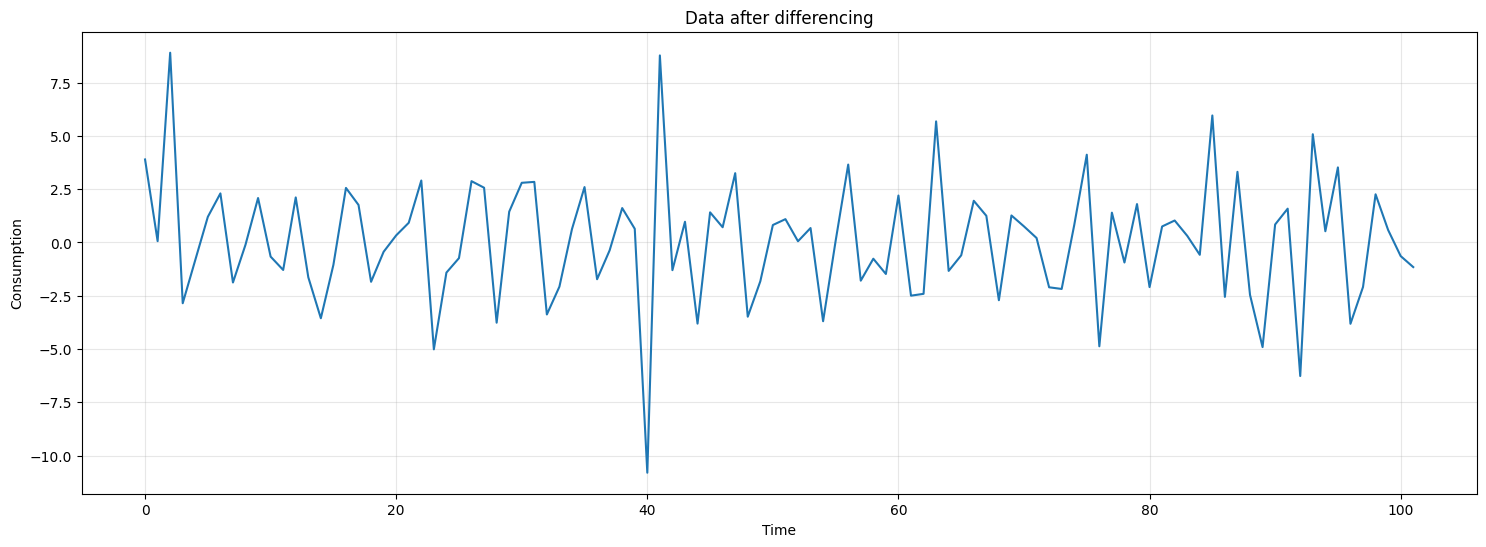

In [144]:
run_seq_plot(diffed_data, 'Data after differencing')

<Axes: >

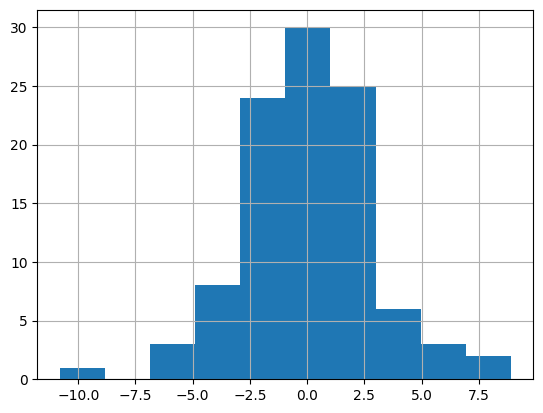

In [145]:
diffed_data.hist()

The data being normal indicates that there is no trend going on.

## Step 2: Model Identification

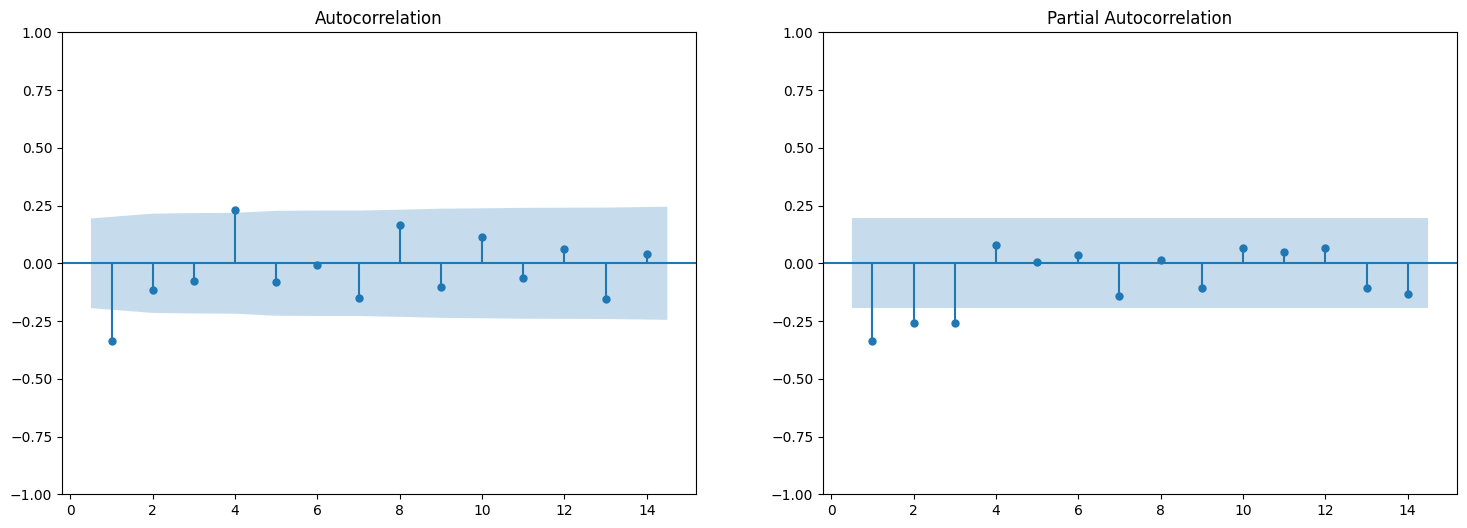

In [141]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

fig, axs = plt.subplots(1,2, figsize=(18,6))
fig = plot_acf(diffed_data, lags=range(1,15), alpha=0.05, ax=axs[0])
fig = plot_pacf(diffed_data, lags=range(1,15), alpha=0.05, ax=axs[1])

According to the **ACF** there are spikes at the fourth and 8th lags which maybe indicates the existance of a seasonal component since we are using weekly data and it concludes a monthe every 4 weeks.

But since both tests claim that the data is stationary we can processed with modeling the data using ARIMA.

Initially, Accroding to the **ACF** We can set the **q** to 1, while according to the **PACF** we can set the **p** to 3.

## Step 3: Parameter Estimation and Model Training

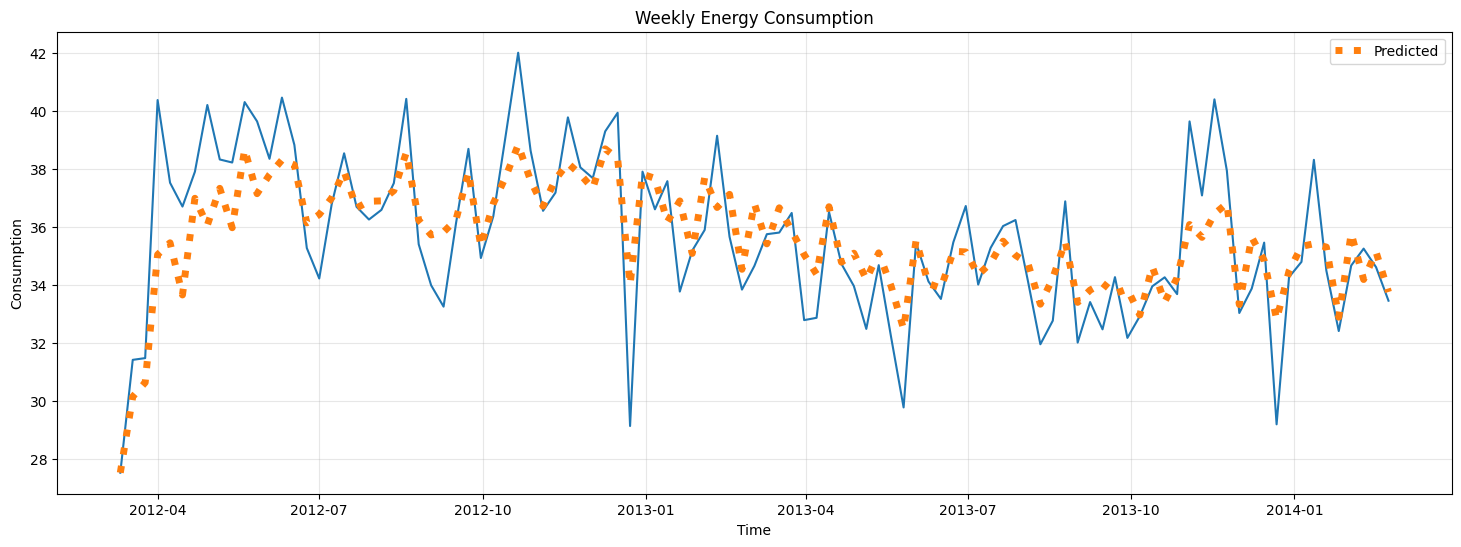

                               SARIMAX Results                                
Dep. Variable:     energy_consumption   No. Observations:                  103
Model:                 ARIMA(1, 1, 3)   Log Likelihood                -237.397
Date:                Tue, 22 Apr 2025   AIC                            484.795
Time:                        00:07:04   BIC                            497.920
Sample:                    03-11-2012   HQIC                           490.110
                         - 02-23-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9280      0.100     -9.283      0.000      -1.124      -0.732
ma.L1          0.3792      0.151      2.517      0.012       0.084       0.675
ma.L2         -0.7607      0.109     -6.947      0.0

In [277]:
from statsmodels.tsa.arima.model import ARIMA

model1 = ARIMA(weekly_df['energy_consumption'], order=(1,1,3), freq='W').fit()
run_seq_plot(weekly_df.energy_consumption, title="Weekly Energy Consumption")
plt.plot(weekly_df.index, model1.predict(start=1, end=len(weekly_df)), label='Predicted', linestyle='dotted', linewidth='5')
plt.legend()
plt.show();
print(model1.summary())

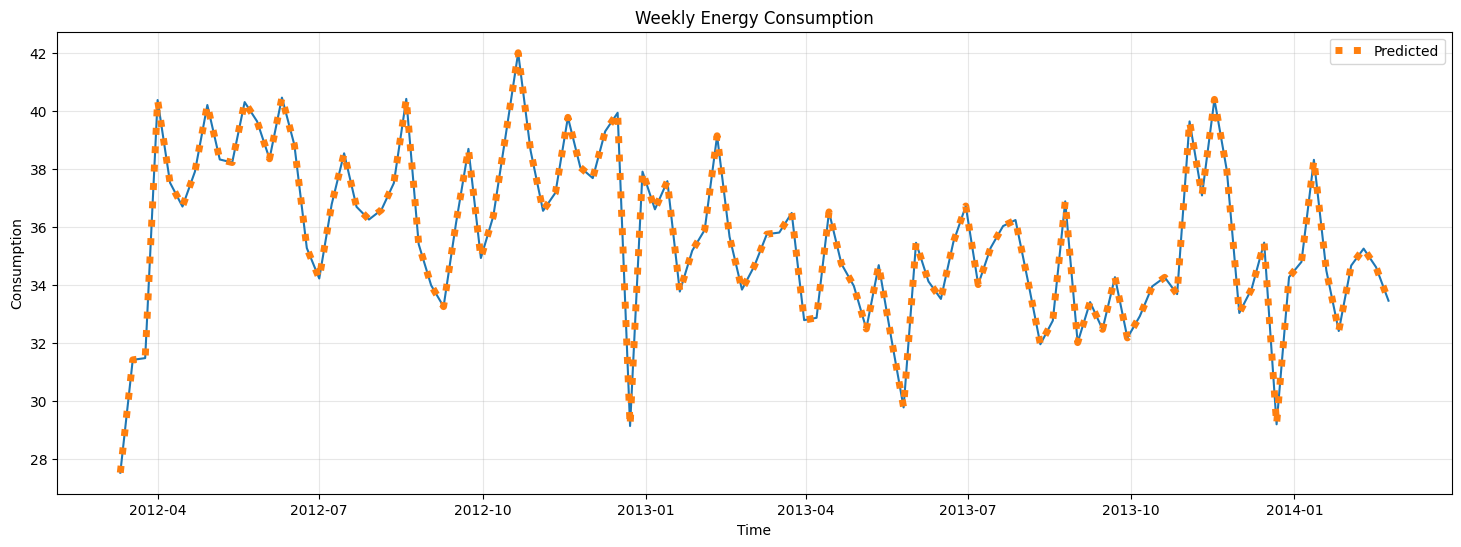

                               SARIMAX Results                                
Dep. Variable:     energy_consumption   No. Observations:                  103
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -253.538
Date:                Tue, 22 Apr 2025   AIC                            509.077
Time:                        00:07:10   BIC                            511.702
Sample:                    03-11-2012   HQIC                           510.140
                         - 02-23-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         8.4442      0.849      9.945      0.000       6.780      10.108
Ljung-Box (L1) (Q):                  11.92   Jarque-Bera (JB):                15.12
Prob(Q):                              0.00   Pr

In [278]:

model2 = ARIMA(weekly_df['energy_consumption'], order=(0,1,0), freq='W').fit()
run_seq_plot(weekly_df.energy_consumption, title="Weekly Energy Consumption")
plt.plot(weekly_df.index, model2.predict(start=1, end=len(weekly_df)), label='Predicted', linestyle='dotted', linewidth='5')
plt.legend()
plt.show();
print(model2.summary())

## Step 4: Model Diagnostics

#### Model 1

<Axes: >

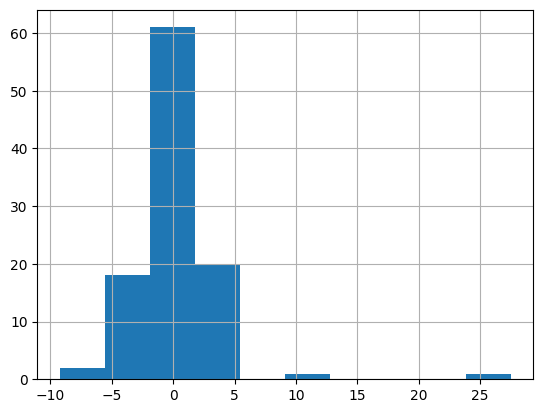

In [272]:
model1.resid.hist()

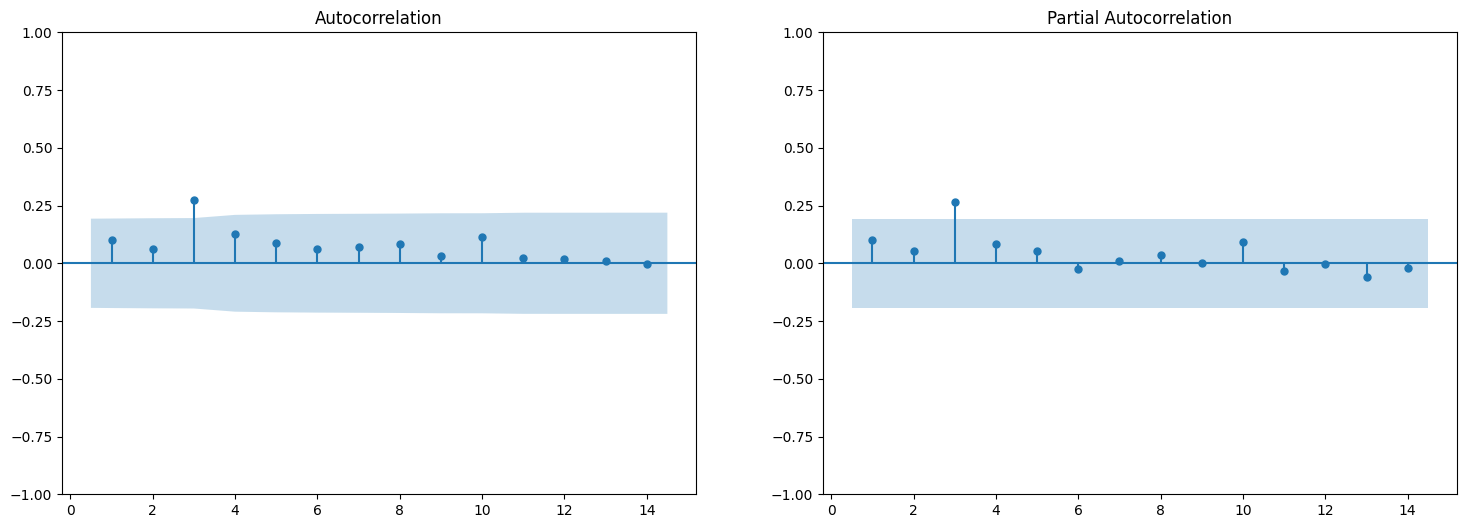

In [275]:
fig, axs = plt.subplots(1,2, figsize=(18,6))
fig = plot_acf(model1.resid, lags=range(1,15), alpha=0.05, ax=axs[0])
fig = plot_pacf(model1.resid, lags=range(1,15), alpha=0.05, ax=axs[1])

#### Model 2

<Axes: >

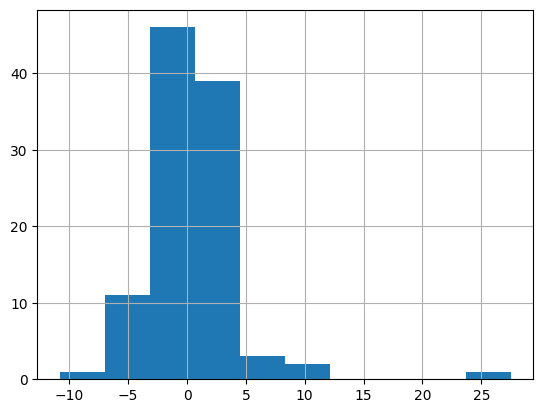

In [274]:
model2.resid.hist()

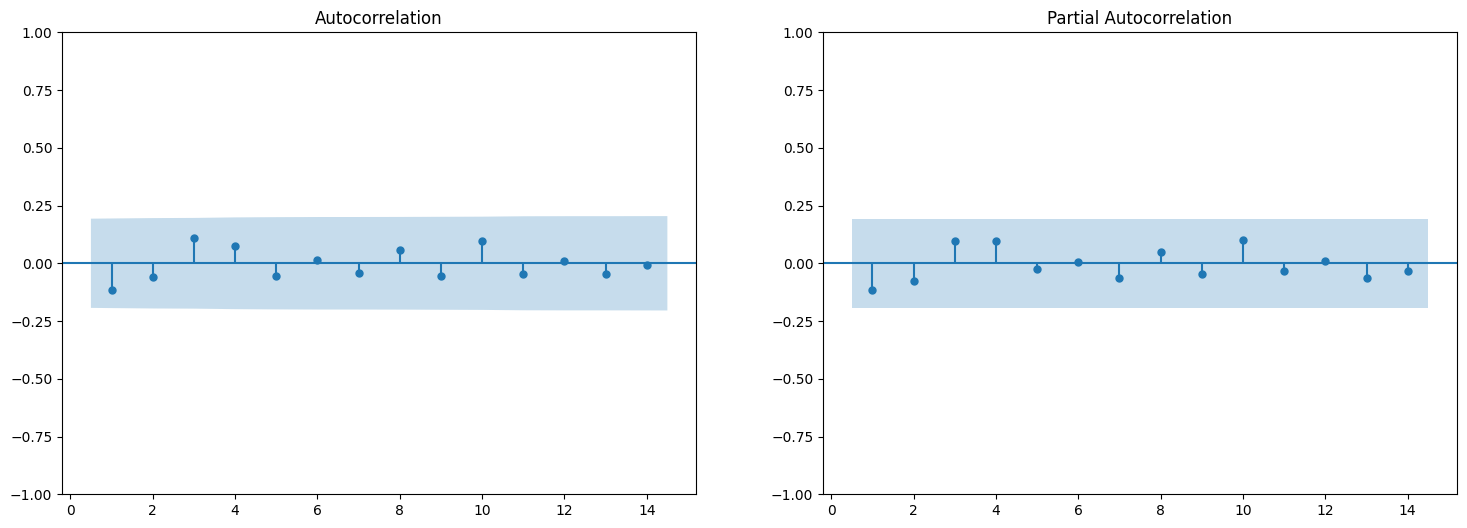

In [276]:
fig, axs = plt.subplots(1,2, figsize=(18,6))
fig = plot_acf(model2.resid, lags=range(1,15), alpha=0.05, ax=axs[0])
fig = plot_pacf(model2.resid, lags=range(1,15), alpha=0.05, ax=axs[1])

Hmm, seems like I interpreted the ACF and PACF in a wrong way, since using an order of (0,1,0) fitted the data better than what I thought should fit it according to the ACF and PACF.

The test summary is in favor of the first model though, as it intriduces smaller AIC, BIC, and HQIC values. Or is it justs simpler model that's why the values are smaller? but according to the Ljung-Box test, the null hypos is that the residuals are independent, so in case of the first model it says that the residuals are indeed independent which means that our model is a good fit and residuals are jusst white noise. In the seconde model though we reject this null hypos and therfore the residuals are likely so we couldn't make a good enough model to capture all the info.

Refrence: [Medium](https://medium.com/@sachinnayak18/reading-arima-results-35eb1df7a565)

### Using AutoARIMA

reference: [AutoARIMA](https://nixtlaverse.nixtla.io/statsforecast/docs/getting-started/getting_started_complete.html)

In [240]:
!pip install -qU statsforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.8/285.8 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 13.9 MB/s eta 0:00:00


In [241]:
from statsforecast.models import AutoARIMA
from statsforecast.core import StatsForecast

In [377]:
sf = StatsForecast( models=[AutoARIMA(alias='arima48', season_length=48)
                            ], # I assume each season is after a year = 48 weeks
                   freq='W',
                   n_jobs=-1)

In [378]:
df = weekly_df.reset_index().copy()
df['unique_id'] = 1.0
# df['ds'] = weekly_df.reset_index()['timestamp']
# df['y'] = weekly_df.energy_consumption

In [379]:
df['ds'] = df['timestamp']
df['y'] = df['energy_consumption']
df=df.drop(['timestamp', 'energy_consumption'], axis=1)
df

,unique_id,ds,y
0,1.0,2012-03-11,27.511
1,1.0,2012-03-18,31.404
2,1.0,2012-03-25,31.464
3,1.0,2012-04-01,40.365
4,1.0,2012-04-08,37.513
...,...,...,...
98,1.0,2014-01-26,32.397
99,1.0,2014-02-02,34.656
100,1.0,2014-02-09,35.240
101,1.0,2014-02-16,34.600


In [386]:
forecasts_df = sf.forecast(df=df, h = 12, level=[90])
forecasts_df.head()

,unique_id,ds,arima48,arima48-lo-90,arima48-hi-90
0,1.0,2014-03-02,34.056236,29.858569,38.253903
1,1.0,2014-03-09,34.338981,29.603135,39.074828
2,1.0,2014-03-16,34.469560,29.567230,39.371889
3,1.0,2014-03-23,34.529864,29.556242,39.503486
4,1.0,2014-03-30,34.557714,29.542878,39.572550


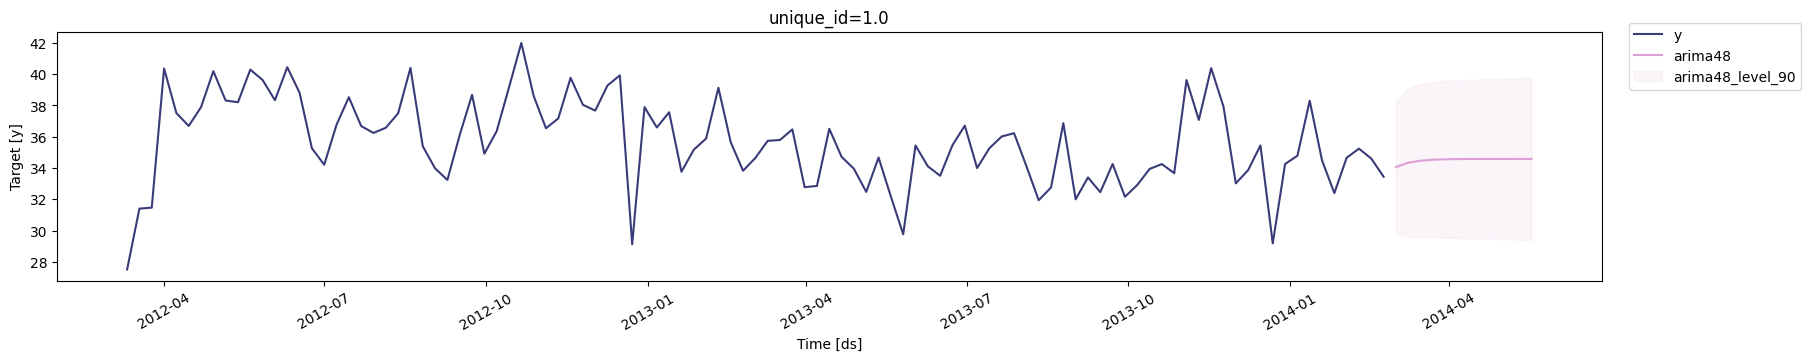

In [388]:
sf.plot(df, forecasts_df, level=[90])

I'd say the previous to models are generally better than this last model. The `model2` was able to fit the data almost perfectly.

## References


1.   [Module 3](https://colab.research.google.com/drive/1cMRQSf8XauB30nD9rkbapuoDrML4T95e)
2.   [Medium](https://medium.com/@sachinnayak18/reading-arima-results-35eb1df7a565)
3.   [Statsforecast](https://nixtlaverse.nixtla.io/statsforecast/docs/getting-started/getting_started_complete.html)

